<font size=6> <b> Machine Learning Example Notebook </b> </font>
<div class="alert alert-block alert-success">
  Time-Series 자동차가 있는 사진에서 번호판을 찾아 번호를 인식해 보자!<br>
</div>
</div>

<p style="text-align:right;"> sumyeon@gmail.com </p>


<hr>

<div class="alert alert-block alert-warning">
<b> 공지: 본 예제는 아래 Github에 올라와 있는 예제를 overview만 제공할 목적으로 몇 가지 커멘트 추가와 코드를 단순화 시킨 자료 입니다. <br>
아래 Github에 3차에 걸친 상세한 설명과 별도 Notebook들이 제공되니 자세한 내용은 아래 링크를 참조바랍니다 <br>
</div>

<div class="alert alert-block alert-warning">
<b> NOTOCE: This notebook is mainly based on the notebook from the below Github Link. Just some comments and code simplification are added for fast overview. <br>
 You can get useful explanation and supplement notebooks from the below link for the detail  <br>
</div>

> https://github.com/quangnhat185/Plate_detect_and_recognize

<hr>

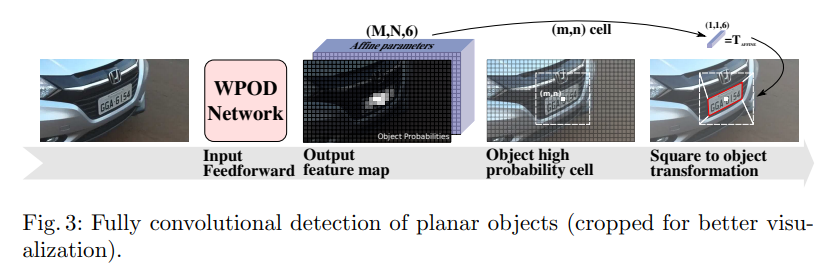

<hr>

# <b> Overview

- 본 프로젝트는 wpod-net이라는 논문에 제안된 내용/모델을 기반으로 작성되었다.
- 아래 그림에서 보는 것 처럼, 자동차가 있는 사진에서, 먼저 자동차 이미지를 추출하고,  <br>
  이 자동차 이미지에서 다시 번호판이 있는 부분을 찾은 뒤에, 이 번호판이 포함된 사각형 이미지 부분을 <br>
  추출한 후에 번호판 부분만을 찾아 다시 사각형으로 transform하는 단계를 거친다 <br>
  마지막 부분에 OCR 을 응용해서 번화판 숫자/문자를 읽어낸다

- 하지만, 아래 예제에서는 마지막 OCR 부분을 별도의 이미지 인식 ML을 구현해서 <br>
 번호판 부분의 숫자/문자를 하나씩 별도 이미지로 분리한 후에 OCR 대신 위 ML을 사용해서 <br>
 문자 인식을 수행한다

- wpod-net 논문을 볼 수 있는곳 <br>
> https://www.researchgate.net/publication/327861610_License_Plate_Detection_and_Recognition_in_Unconstrained_Scenarios

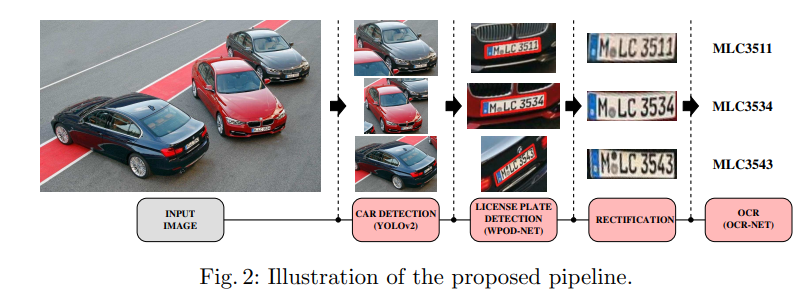

<hr>

# <b> Preparation </b>

##  package/module import

In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from os.path import splitext, basename
from keras.models import model_from_json
import glob
import matplotlib.gridspec as gridspec

from local_utils import detect_lp


%matplotlib inline

## wpod-net model load

- 논문에서 공유된 wpod-net 모델을 로딩한다. <br>
- 모델 구조뿐 아니라 pre-trained된 weight 값도 로딩한다.

In [6]:
with open("wpod-net.json",'r') as json_file:
    model_json = json_file.read()
wpod_net = model_from_json(model_json, custom_objects={})
wpod_net.load_weights("wpod-net.h5")

- 자동차가 포함된 이미지 파일을 읽어와, 컬러 변환 (opencv는 RGB, jpg는 BGR 사용)과 resize를 수행하는 함수

In [18]:
def preprocess_image(image_path, resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (640,640))
    return img

- 샘플용 이미지를 출력해 보자

Found 23 images...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


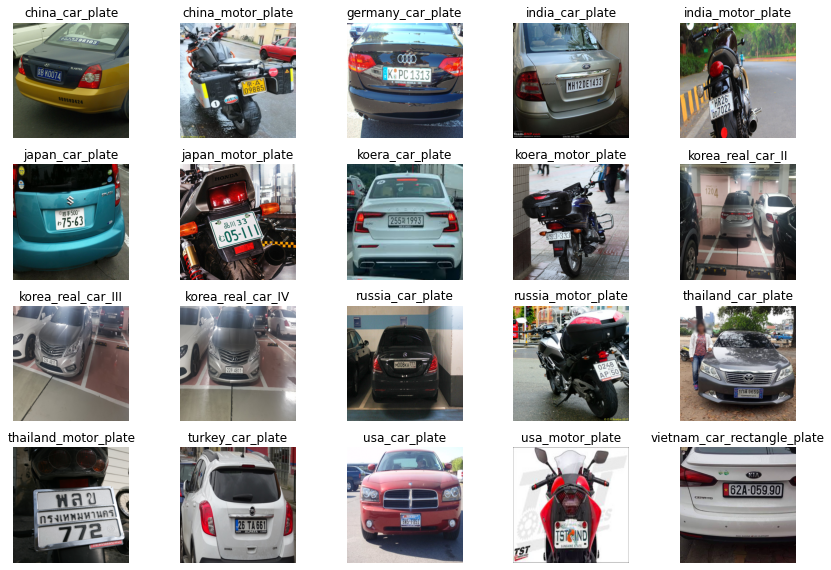

In [44]:
# Create a list of image paths 
image_paths = glob.glob("./Plate_examples/*.jpg")
print("Found %i images..."%(len(image_paths)))

# Visualize data in subplot 
fig = plt.figure(figsize=(12,8))
cols = 5
rows = 4
fig_list = []
for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    img = preprocess_image(image_paths[i],True)
    plt.axis(False)
    plt.imshow(img)

plt.tight_layout(True)
plt.show()

- 자동차 사진을로부터 License Plate 이미지를 ML을 통해 인식하고, 가져오는 함수 <br>
 > detect_lp의 LpImg는 추출된 번호판 이미지가, cor에는 원본 이미지의 번호판 사각형의 좌표 정보가 있음

   <pre>
    x_cor = cor[0][0]   #  list of four floats
    y_cor = cor[0][1]   #  list of four floats
    
    lp_box = []
    for i in range(4):
        lp_box.append((x_cor[i],y_cor[i]) ) # store the top-left, top-right, bottom-right, bottom-left 
   </pre>

- 자동차 사진을 하나 선택해, get_plate 함수로 작업 후 결과를 표시

Detect 1 plate(s) in korea_real_car_II
Coordinate of plate(s) in image: 
 [array([[422.70356093, 515.47836653, 515.29535714, 422.52055154],
       [238.53672744, 239.6678419 , 263.55307922, 262.42196477],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]


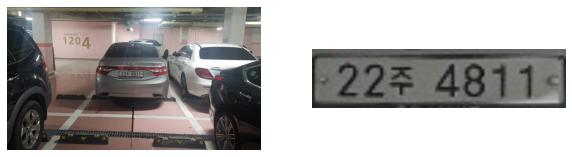

In [113]:
# Obtain plate image and its coordinates from an image
test_image = "./Plate_examples/germany_car_plate.jpg"
LpImg,cor = get_plate(test_image)
print("Detect %i plate(s) in"%len(LpImg),splitext(basename(test_image))[0])
print("Coordinate of plate(s) in image: \n", cor)

# Visualize our result
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(preprocess_image(test_image))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])

- 추출된 번호판 정보를 활용해서, 번호판 주변을 표시해보자 (optional)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


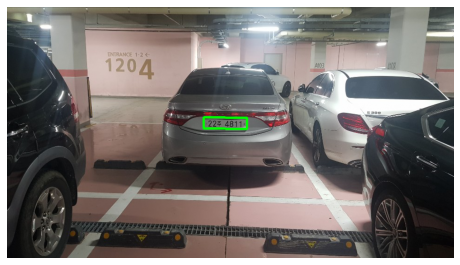

In [114]:
def draw_box(image_path, cor, thickness=3): 
    pts=[]  
    x_coordinates=cor[0][0]
    y_coordinates=cor[0][1]
    # store the top-left, top-right, bottom-right, bottom-left 
    # of the plate license respectively
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])
    
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    vehicle_image = preprocess_image(image_path)
    
    cv2.polylines(vehicle_image,[pts],True,(0,255,0),thickness)
    return vehicle_image

plt.figure(figsize=(8,8))
plt.axis(False)
plt.imshow(draw_box(test_image,cor))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


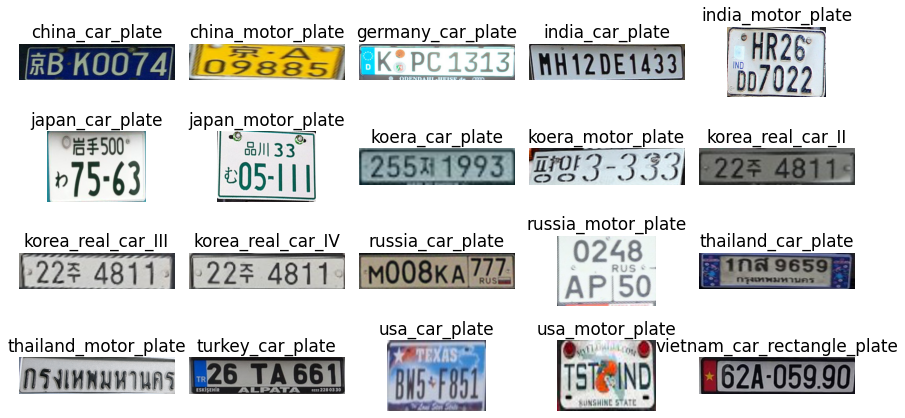

In [115]:
# Viualize all obtained plate images 
fig = plt.figure(figsize=(12,6))
cols = 5
rows = 4
fig_list = []

for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    LpImg,_ = get_plate(image_paths[i])
    plt.axis(False)
    plt.imshow(LpImg[0])

plt.tight_layout(True)
plt.show()

## Part 2: Segementing license characters

- 추출된 번호판 이미지에서 글자/숫자별로 이미지를 분리해 내고 싶다

In [123]:
test_image = "./Plate_examples/germany_car_plate.jpg"
LpImg,cor = get_plate(test_image)

- 먼저, 추출된 번호판 이미지를 전처리를 통해 글자/숫자 분리에 좀 더 유리하도록 하자

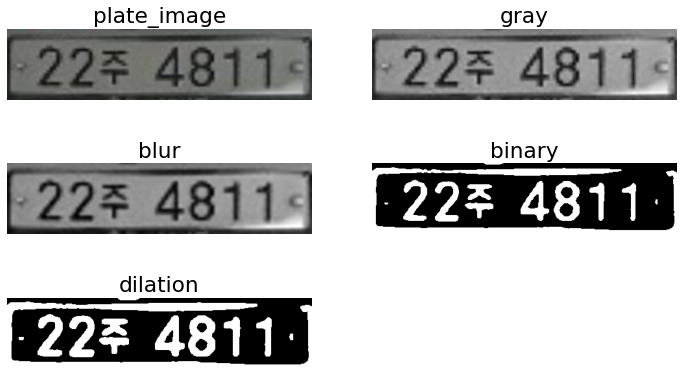

In [124]:
if (len(LpImg)): #check if there is at least one license image
    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    
    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    
# visualize results    
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
plot_image = [plate_image, gray, blur, binary,thre_mor]
plot_name = ["plate_image","gray","blur","binary","dilation"]

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i ==0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i],cmap="gray")

# plt.savefig("threshding.png", dpi=300)

- 추출된 번호판 이미지에서 글자/숫자별로 이미지를 분리해 내자

In [125]:
# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

In [126]:
cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

<div class="alert alert-block alert-warning">
<b> 번호판 이미지에서 개별 숫자/문자 부위를 인식하는 방법으로 opencv의 findContours 함수를 이용했습니다. <br>
    매우 단순하고 확실한 방법이지만 한글과 같이 하나 이상의 서로 분리된 부분이 모여 하나의 문자를 이루는 경우 <br>
    위와 같은 간단한 방법으로는 구분이 불가 합니다. 이런 부분에 대해서는 추가적인 turning이 필요합닏다. 
</div>

Detect 6 letters...


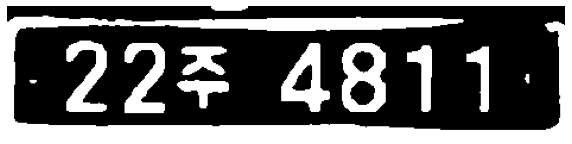

In [127]:
# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = binary.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 30, 60

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=3.5: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Sperate number and gibe prediction
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)

print("Detect {} letters...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi, cmap='gray')
#plt.savefig('grab_digit_contour.png',dpi=300)

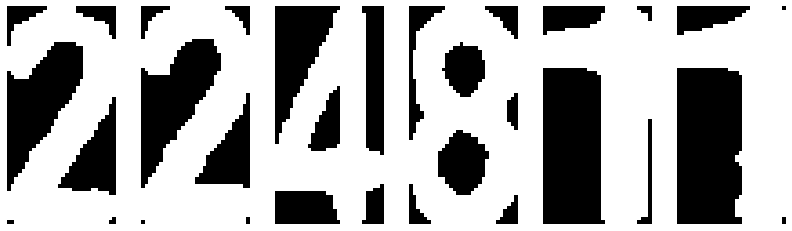

In [128]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")
#plt.savefig("segmented_leter.png",dpi=300)    

# Part 3 : Character recognition

- Keras의 MobileNetV2 모델을 사용해서 문자/숫자를 인식하는 ML을 만들고 학습 시켜 보자 (Optional)

<div class="alert alert-block alert-warning">
<b> 이하, 문자 인식을 실제로 수행하는 부분전까지 모델을 만들고 training을 수행하는 부분은 매우 많은 리소스가 필요한 부분입니다. <br>
    GPU 지원이 없는 상황에서는 상당한 시간 (10여시간 이상)이 학습에 필요하니 실제 학습 부분은 필요할 경우 skip 하셔도 됩니다. <br>
</div>

In [107]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import numpy as np

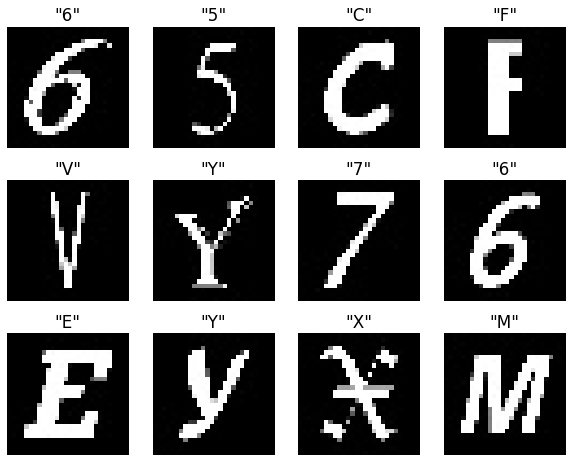

In [108]:
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

dataset_paths = glob.glob("./dataset_characters/**/*.jpg")

cols=4
rows=3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(45)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))

# Plot example images
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

<div class="alert alert-block alert-warning">
<b> 위와 같이 실제 학습 데이터에 숫자와 영어 알파벳만이 포함되어 있습니다. <br>
    앞서 알려드린 바와 같이 알파벳 이외에는 현재 문자 이미지를 구분하지 못하기에 이번 프로젝트에서는 문제가 없습니다. <br>
    만약 실제 환경에서 사용을 하기 위해서는, 인식하고자 하는 문자에 대한 이미지들을 구하여 학습을 진행하시면 됩니다. <br>
    ( 머신 러닝의 특성 덕분에, 추가적인 코딩 없이 학습 이미지만 추가하시면 됩니다. )
</div>

In [109]:
from keras.preprocessing.image import img_to_array

In [110]:
# Arange input data and corresponding labels
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image=load_img(image_path,target_size=(80,80))
  image=img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))

# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file so we can use in another script
np.save('license_character_classes.npy', lb.classes_)

# split 10% of data as validation set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)


# generate data augumentation method
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )

KeyboardInterrupt: 

In [ ]:
# Create our model with pre-trained MobileNetV2 architecture from imagenet
def create_model(lr=1e-4,decay=1e-4/25, training=False,output_shape=y.shape[1]):
    baseModel = MobileNetV2(weights="imagenet", 
                            include_top=False,
                            input_tensor=Input(shape=(80, 80, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(output_shape, activation="softmax")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    if training:
        # define trainable lalyer
        for layer in baseModel.layers:
            layer.trainable = True
            
        # compile model
        optimizer = Adam(lr=lr, decay = decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])    
        
    return model

# initilaize initial hyperparameter
INIT_LR = 1e-4
EPOCHS = 30

model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)


- 위의 방법과 같이 생성된 ML 모델을 가지고 위에서 구한 번호판의 개별 문자/숫자를 인식해 보자

In [129]:
# Load model architecture, weight and labels
json_file = open('MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("License_character_recognition_weight.h5")
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


Achieved result:  224811


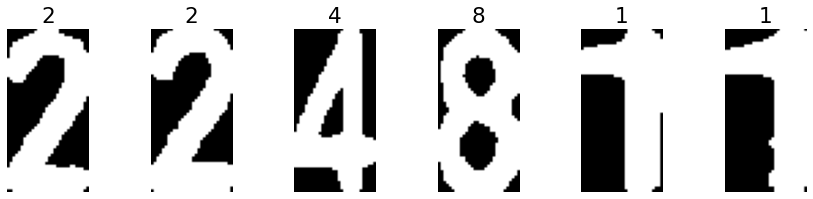

In [130]:
# pre-processing input images and pedict with model
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction
    
fig = plt.figure(figsize=(15,3))
cols = len(crop_characters)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(crop_characters):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,model,labels))
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')

    
print("Achieved result: ", final_string)
#plt.savefig('final_result.png', dpi=300)